# Overfitting & Underfitting

<br>

- 앞선 4. 에서 일정 epoch동안 훈련하면 **val set에서 모델 성능이 최고점에 도달한 후 감소하기 시작**했음.
- 이건 모델이 **train set에 overfit 된 것.** 과대적합이 발생했다.
- train set에서 높은 성능을 얻을 수는 있지만, **우리가 진짜 원하는 것은 test set (또는 본적 없는 데이터)에 잘 일반화 되는 모델.**

<br>

- **과소적합(Underfitting)**? **test set에 대한 성능이 향상될 수 있을때 발생*. 발생 원인은 많음.
    - 모델이 너무 단순하거나, 규제가 너무 많거나, 오래 훈련하지 못했거나.*
    - 네트워크가 **train set에서 적절한 패턴을 학습하지 못한 경우**.
    
<br>

- 그렇다고 **모델을 너무 오래 훈련하면 과대적합이 발생함**. 
- test set에서 일반화 되지 못하는 패턴을 train set에서 학습하기 시작하는 셈.
- 과대적합과 과소적합 사이에서 적절한 균형을 잡아야 함. 

<br>

- 방지할 수 있는 방법들엔 뭐가 있을까?
    1. **더 많은 훈련 데이터 사용**. 많은 데이터로 학습할수록 자연적으로 일반화 성능이 좋아지게 됨.
    2. 데이터를 준비할 수 없다면 **정규화 같은 규제를 적용**하는 것. 모델이 저장할 수 있는 정보의 양과 종류에 제약을 거는 방법.
    3. **조기 종료**. 과대적합이 발생할 것 같은 시점에 학습을 종료하는 방법.
    4. **드롭-아웃**. 불필요한 유닛을 제거하는 방법.

In [2]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('ggplot')

## Dataset load

<br>

- 이번엔 Embedding이 아닌 multi-hot encoding 해보자.
    - 정수 시퀀스를 0과 1로 이뤄진 벡터로 변환.
    - 시퀀스 [3,5]를 인덱스 3과 5만 1로 두고, 나머지는 모두 0인 10,000차원 벡터로 변환.
- 이 모델은 train set에 빠르게 과대적합 될 것. 어떻게 해결하는지 과정을 살펴보자.

In [4]:
NUM_WORDS = 1000

(train_data, train_labels), (test_data, test_labels) = keras.datasets.imdb.load_data(num_words=NUM_WORDS)

def multi_hot_sequences(sequences, dimension):
    # 0으로 채워진 (len(sequences), dimension)크기의 행렬 생성
    results = np.zeros((len(sequences), dimension))
    
    # results[i]의 특정 인덱스만 1로 설정.
    for i, word_indices in enumerate(sequences):
        results[i, word_indices] = 1.0
    return results

train_data = multi_hot_sequences(train_data, dimension=NUM_WORDS)
test_data = multi_hot_sequences(test_data, dimension=NUM_WORDS)

     multi-hot 벡터 중 하나를 살펴보자.
     단어 인덱스는 빈도 순으로 정렬되어 있음. 인덱스 0에 가까울수록 1이 많이 등장함.

C:\Users\skdbs\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1241: UserWarning: findfont: Font family ['gulim'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


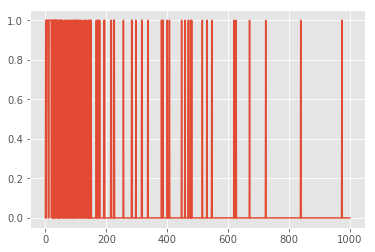

In [4]:
plt.plot(train_data[0])

## Overfitting Example

<br>

- 과대적합을 막는 **가장 간단한 방법은 모델의 규모를 축소**하는 것.
    - 모델에 있는 **trainable한 하이퍼 파라미터 수를 줄이는 것.**
    - 파라미터는 층(layer) 개수와 층의 유닛(unit)개수에 의해 결정. 신경망 구조 알고있으면 알죠?
- trainable한 하이퍼 파라미터 수를 **"용량"** 으로 부르기도 함.
- 직관적으로 생각해보면, 많은 파라미터를 가진 모델은 더 많은 "기억 용량"을 갖게 될 것.
    - 이런 모델은 훈련 샘플과 타겟 사이를 딕셔너리와 같은 매핑으로 완벽히 학습 할 수는 있음.
    - 히지만 처음 보는 데이터에서 예측할 땐 쓸모가 없어질 것.

            진짜 해결해야할 문제는 학습이 아닌 모델을 일반화 하는 것.

- 하지만 **네트워크의 기억 용량이 부족하다면 매핑을 쉽게 하지 못할 것.**
- 너무 많은 용량과 충분하지 않은 용량 사이의 균형을 잘 잡아야 한다.
- 그치만 이런 적절한 크기나 구조를 결정하는 마법은 없어요. 실험을 통해 **직접 발견해야 함.**

<br>

- 적당한 모델 크기를 찾으려면 **적은 수의 층과 파라미터로 시작**해, 
- **검증 손실이 감소할 때 까지 새로운 층을 추가하거나 층의 크기를 늘리는 방법**이 좋음.

### Baseline model build

In [5]:
baseline_model = keras.Sequential([
    # .summary 메서드 때문에 input_shape가 필요하다 함. 뭔소린지...
    keras.layers.Dense(16, activation='relu', input_shape=(NUM_WORDS,)),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

baseline_model.compile(optimizer='adam',
                       loss='binary_crossentropy',
                       metrics=['accuracy', 'binary_crossentropy'])
baseline_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                16016     
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 16,305
Trainable params: 16,305
Non-trainable params: 0
_________________________________________________________________


In [6]:
with tf.device('/GPU:0'):
    baseline_history = baseline_model.fit(train_data, train_labels,
                                          epochs=20, batch_size=512,
                                          validation_data=(test_data, test_labels), verbose=2)

Epoch 1/20
49/49 - 0s - loss: 0.5636 - accuracy: 0.7119 - binary_crossentropy: 0.5636 - val_loss: 0.4140 - val_accuracy: 0.8243 - val_binary_crossentropy: 0.4140
Epoch 2/20
49/49 - 0s - loss: 0.3605 - accuracy: 0.8471 - binary_crossentropy: 0.3605 - val_loss: 0.3419 - val_accuracy: 0.8570 - val_binary_crossentropy: 0.3419
Epoch 3/20
49/49 - 0s - loss: 0.3217 - accuracy: 0.8646 - binary_crossentropy: 0.3217 - val_loss: 0.3309 - val_accuracy: 0.8594 - val_binary_crossentropy: 0.3309
Epoch 4/20
49/49 - 0s - loss: 0.3077 - accuracy: 0.8726 - binary_crossentropy: 0.3077 - val_loss: 0.3278 - val_accuracy: 0.8607 - val_binary_crossentropy: 0.3278
Epoch 5/20
49/49 - 0s - loss: 0.3019 - accuracy: 0.8758 - binary_crossentropy: 0.3019 - val_loss: 0.3273 - val_accuracy: 0.8606 - val_binary_crossentropy: 0.3273
Epoch 6/20
49/49 - 0s - loss: 0.2980 - accuracy: 0.8762 - binary_crossentropy: 0.2980 - val_loss: 0.3272 - val_accuracy: 0.8604 - val_binary_crossentropy: 0.3272
Epoch 7/20
49/49 - 0s - loss

### Tiny Model build

<br>

- 앞서 만든 baseline 모델과 비교하기 위해 
- 적은 수의 hidden unit을 가진 모델을 만들어보자.

In [7]:
smaller_model = keras.Sequential([
    keras.layers.Dense(4, activation='relu', input_shape=(NUM_WORDS,)),
    keras.layers.Dense(4, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

smaller_model.compile(optimizer='adam',
                      loss='binary_crossentropy',
                      metrics=['accuracy', 'binary_crossentropy'])

smaller_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 4)                 4004      
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 20        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 5         
Total params: 4,029
Trainable params: 4,029
Non-trainable params: 0
_________________________________________________________________


    baseline 보다 하이퍼 파라미터 수가 약 4배 정도 적음.

In [8]:
# 같은 데이터를 써서 훈련해보자.
with tf.device('/GPU:0'):
    smaller_history = smaller_model.fit(train_data, train_labels,
                                        epochs=20, batch_size=512,
                                        validation_data=(test_data, test_labels), verbose=2)

Epoch 1/20
49/49 - 0s - loss: 0.6834 - accuracy: 0.5844 - binary_crossentropy: 0.6834 - val_loss: 0.6561 - val_accuracy: 0.6633 - val_binary_crossentropy: 0.6561
Epoch 2/20
49/49 - 0s - loss: 0.6280 - accuracy: 0.6739 - binary_crossentropy: 0.6280 - val_loss: 0.6004 - val_accuracy: 0.7196 - val_binary_crossentropy: 0.6004
Epoch 3/20
49/49 - 0s - loss: 0.5658 - accuracy: 0.7521 - binary_crossentropy: 0.5658 - val_loss: 0.5425 - val_accuracy: 0.7848 - val_binary_crossentropy: 0.5425
Epoch 4/20
49/49 - 0s - loss: 0.5170 - accuracy: 0.8121 - binary_crossentropy: 0.5170 - val_loss: 0.5076 - val_accuracy: 0.8224 - val_binary_crossentropy: 0.5076
Epoch 5/20
49/49 - 0s - loss: 0.4865 - accuracy: 0.8394 - binary_crossentropy: 0.4865 - val_loss: 0.4856 - val_accuracy: 0.8375 - val_binary_crossentropy: 0.4856
Epoch 6/20
49/49 - 0s - loss: 0.4649 - accuracy: 0.8535 - binary_crossentropy: 0.4649 - val_loss: 0.4698 - val_accuracy: 0.8466 - val_binary_crossentropy: 0.4698
Epoch 7/20
49/49 - 0s - loss

### Large Model build

<br>

- 앞선 모델들 보다 더 큰 모델(더 큰 용량을 가진 네트워크)을 만들어
- 과대적합이 얼마나 빠르게 발생하는지 봐보자.

In [9]:
bigger_model = keras.Sequential([
    keras.layers.Dense(512, activation='relu', input_shape=(NUM_WORDS,)),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

bigger_model.compile(optimizer='adam',
                     loss='binary_crossentropy',
                     metrics=['accuracy', 'binary_crossentropy'])

bigger_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 512)               512512    
_________________________________________________________________
dense_7 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 513       
Total params: 775,681
Trainable params: 775,681
Non-trainable params: 0
_________________________________________________________________


    하이퍼 파라미터 수가
    작은 모델보다 약 192배, baseline 모델보다 약 47배 많음.

In [10]:
with tf.device('/GPU:0'):
    bigger_history = bigger_model.fit(train_data, train_labels,
                                      epochs=20, batch_size=512,
                                      validation_data=(test_data, test_labels), verbose=2)

Epoch 1/20
49/49 - 0s - loss: 0.4479 - accuracy: 0.7834 - binary_crossentropy: 0.4479 - val_loss: 0.3314 - val_accuracy: 0.8584 - val_binary_crossentropy: 0.3314
Epoch 2/20
49/49 - 0s - loss: 0.2918 - accuracy: 0.8789 - binary_crossentropy: 0.2918 - val_loss: 0.3306 - val_accuracy: 0.8554 - val_binary_crossentropy: 0.3306
Epoch 3/20
49/49 - 0s - loss: 0.2313 - accuracy: 0.9073 - binary_crossentropy: 0.2313 - val_loss: 0.3370 - val_accuracy: 0.8554 - val_binary_crossentropy: 0.3370
Epoch 4/20
49/49 - 0s - loss: 0.1158 - accuracy: 0.9641 - binary_crossentropy: 0.1158 - val_loss: 0.4133 - val_accuracy: 0.8486 - val_binary_crossentropy: 0.4133
Epoch 5/20
49/49 - 0s - loss: 0.0249 - accuracy: 0.9962 - binary_crossentropy: 0.0249 - val_loss: 0.5251 - val_accuracy: 0.8464 - val_binary_crossentropy: 0.5251
Epoch 6/20
49/49 - 0s - loss: 0.0045 - accuracy: 0.9998 - binary_crossentropy: 0.0045 - val_loss: 0.6263 - val_accuracy: 0.8488 - val_binary_crossentropy: 0.6263
Epoch 7/20
49/49 - 0s - loss

    정확도가 100%래요 ㅋㅋㅋ

## Train Loss & Validation Loss Visualization

<br>

- train loss(실선), val loss(점선)를 그래프로 그려서 한번 봐보자.
- val loss가 낮을수록 더 좋은 모델.

C:\Users\skdbs\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1241: UserWarning: findfont: Font family ['gulim'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


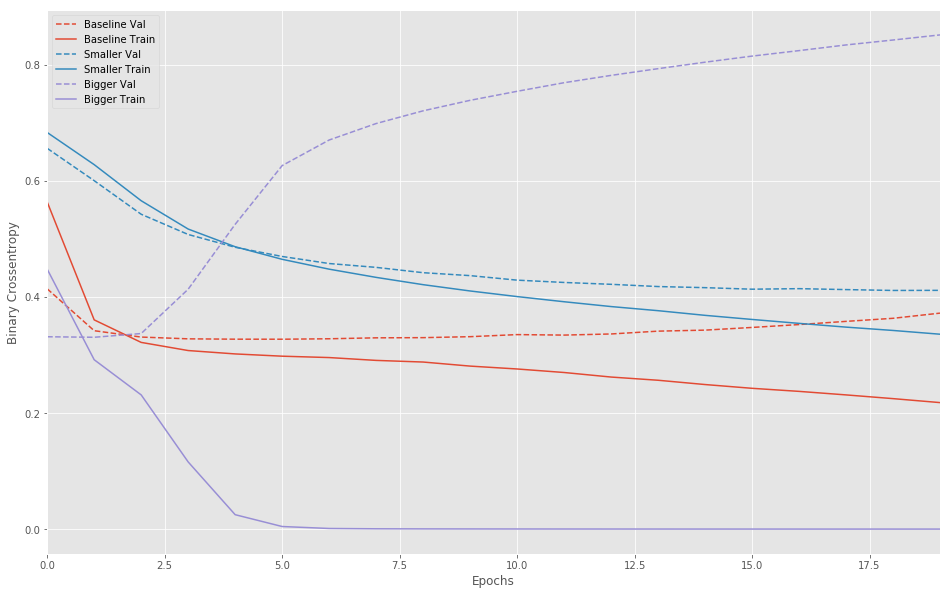

In [11]:
def plot_history(histories, key='binary_crossentropy'):
    plt.figure(figsize=(16, 10))
    
    for name, history in histories:
        val = plt.plot(history.epoch, history.history['val_'+key],
                       '--', label=name.title()+' Val')
        plt.plot(history.epoch, history.history[key], color=val[0].get_color(),
                 label=name.title()+' Train')
    plt.xlabel('Epochs')
    plt.ylabel(key.replace('_', ' ').title())
    plt.legend()
    
    plt.xlim([0, max(history.epoch)])
    
plot_history([('baseline', baseline_history), 
              ('smaller', smaller_history), 
              ('bigger', bigger_history)])

- baseline은 약 3~3.5 즈음에서 과적합이 발생되는거 같아 보임.
- smaller는 baseline보단 늦게 약 6~8 즈음에서 과적합이 발생되는거 같아 보임.
- bigger는 둘보다 더 빠른 약 1.0 즈음에서 과적합이 발생되는거 같아 보임.

- bigger는 첫 epoch 후로 과대적합이 시작되고, 이후로 훨씬 더 심각하게 과대적합이 발생하는 듯 하다.
    - 실제로 정확도가 100%로 나오는거 보면...
- 네트워크의 용량이 클수록 train set을 더 빠르게 모델링 할 수 있지만, 더 쉽게 overfit 됨.
    - train loss는 빠르게 낮아지지만, train loss와 val loss 사이 차이가 커진다는 의미.

## How to prevent Overfitting problems?

<br>

### Regularization

<br>

오컴의 면도날 이야기 처럼, **어떤 것을 설명하는 두 가지 방법이 있다면**   <br>
**더 정확한 설명은 최소한의 가정이 필요한 가장 간단한 설명**일 것.  <br>
신경망으로 학습되는 모델에도 동일하게 적용 됨.

<br>

- 여기서 말하는 '간단한 모델'은 모델의 **하이퍼 파라미터들의 분포를 봤을 때, entropy가 작은 모델.**
    - 또는 **적은 파라미터 수**를 가진 모델.
- **가중치가 작은 값을 갖도록 네트워크의 복잡도에 제약을 가하는 것**이 과대적합을 방지하는 일반적인 방법.
    - **가중치 값의 분포를 좀 더 균일하게** 만들어줌.
    - 이를 **가중치 규제(weight regularization)** 또는 **가중치 정규화** 라고 함.

<br>

- 신경망의 loss function에 큰 가중치에 해당하는 비용을 추가하는 것. 2가지 형태의 비용이 있다.
    1. **L1 regularization** : 가중치의 **절댓값에 비례하는 패널티** 부여. 가중치에 L1 norm을 추가. 
    2. **L2 regularization** : 가중치의 **제곱에 비례하는 패널티** 부여. 가중치에 L2 norm의 제곱을 추가.
- L1 규제는 **일부 가중치 파라미터를 0으로 만들어 버림**. 장점이면서도 어떻게 보면 사용이 한정됨.
- L2 규제는 가중치 파라미터를 제한하긴 하지만, **완전히 0으로 만들진 않음**.
    - 그래서 L2 규제를 더 많이 사용함.

    keras에선 가중치 규제 객체를 layer의 키워드 매개변수에 전달해 규제를 추가할 수 있음.
    얼마나 쉬운가

In [12]:
l2_model = keras.Sequential([
    keras.layers.Dense(16, kernel_regularizer=keras.regularizers.l2(0.001),
                       activation='relu', input_shape=(NUM_WORDS,)),
    keras.layers.Dense(16, kernel_regularizer=keras.regularizers.l2(0.001),
                       activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

l2_model.compile(optimizer='adam',
                 loss='binary_crossentropy',
                 metrics=['accuracy', 'binary_crossentropy'])

with tf.device('/GPU:0'):
    l2_model_history = l2_model.fit(train_data, train_labels,
                                    epochs=20, batch_size=512,
                                    validation_data=(test_data, test_labels), verbose=2)

Epoch 1/20
49/49 - 0s - loss: 0.6996 - accuracy: 0.6365 - binary_crossentropy: 0.6549 - val_loss: 0.6021 - val_accuracy: 0.7695 - val_binary_crossentropy: 0.5616
Epoch 2/20
49/49 - 0s - loss: 0.4978 - accuracy: 0.8244 - binary_crossentropy: 0.4580 - val_loss: 0.4240 - val_accuracy: 0.8451 - val_binary_crossentropy: 0.3843
Epoch 3/20
49/49 - 0s - loss: 0.3866 - accuracy: 0.8590 - binary_crossentropy: 0.3470 - val_loss: 0.3759 - val_accuracy: 0.8596 - val_binary_crossentropy: 0.3368
Epoch 4/20
49/49 - 0s - loss: 0.3557 - accuracy: 0.8690 - binary_crossentropy: 0.3173 - val_loss: 0.3658 - val_accuracy: 0.8619 - val_binary_crossentropy: 0.3283
Epoch 5/20
49/49 - 0s - loss: 0.3434 - accuracy: 0.8734 - binary_crossentropy: 0.3067 - val_loss: 0.3646 - val_accuracy: 0.8594 - val_binary_crossentropy: 0.3287
Epoch 6/20
49/49 - 0s - loss: 0.3370 - accuracy: 0.8750 - binary_crossentropy: 0.3018 - val_loss: 0.3594 - val_accuracy: 0.8615 - val_binary_crossentropy: 0.3249
Epoch 7/20
49/49 - 0s - loss

- **kernel_regularizer=keras.regularizers.l2(0.001)** 를 통해 규제를 걸어줬음.
    - 전체 loss에 대해, layer에 있는 가중치 행렬의 모든 값이 0.001 * (weight_coefficient_value)^2 만큼 더해진다는 의미.
    - 이런 규제는 훈련할 때만 가해짐. test 단계 보다 train 단계에서 loss가 더 클 것.
- 효과를 한번 확인해보자.

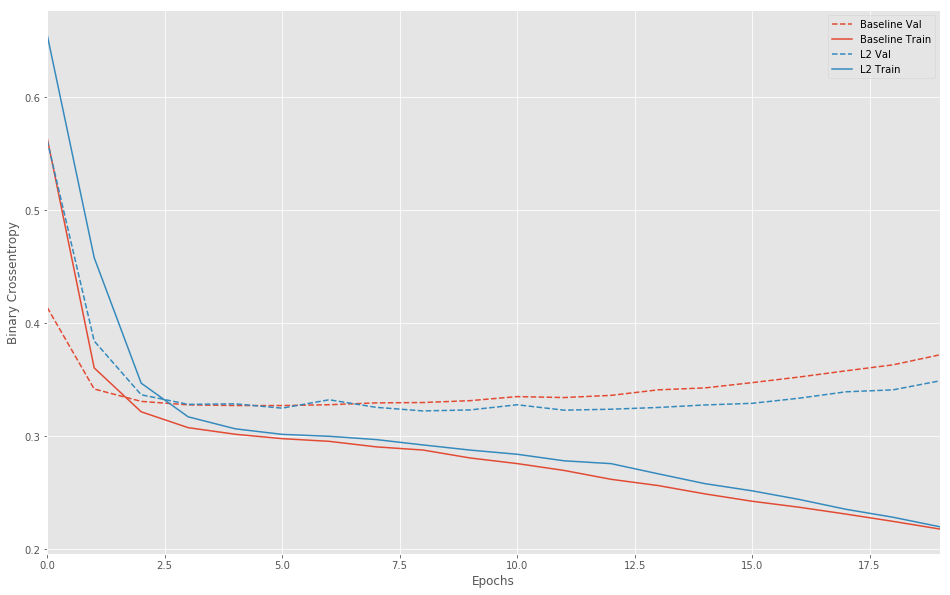

In [13]:
plot_history([('baseline', baseline_history), 
              ('l2', l2_model_history)])

    l2규제를 사용한 모델이 baseline 모델 보다 
    과대적합이 좀 더 느리게 나타나고 있음. 어느정도 견디긴 한다.

### Add Dropout

<br>

- Regularization 이외에 사용하는 규제 기법. 효과적이고 널리 사용 중.
- layer에 dropout을 적용하면, **훈련하는 동안 layer의 출력 특성을 랜덤하게 off** 한다.
    - 즉 0으로 만든단 소리. **출력을 안한다**는 소리. 연결되지 않은 것 처럼. 연결을 끊는 셈.
- 역전파 수행 시 그래디언트 계산 또한 안함. 
- test할땐 일반적으로 드롭아웃은 끔.

    Dropout 층을 추가해 과대적합이 얼마나 감소하는지 한번 봐보자.
    
    단순히 Dense layer 다음에 Dropout layer 추가해 주면 된다. 얼마나 간편한가...

In [14]:
dropout_model = keras.Sequential([
    keras.layers.Dense(16, activation='relu', input_shape=(NUM_WORDS,)),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1, activation='sigmoid')
])

dropout_model.compile(optimizer='adam',
                      loss='binary_crossentropy',
                      metrics=['accuracy', 'binary_crossentropy'])

with tf.device('/GPU:0'):
    dropout_model_history = dropout_model.fit(train_data, train_labels,
                                              epochs=20, batch_size=512,
                                              validation_data=(test_data, test_labels), verbose=2)

Epoch 1/20
49/49 - 0s - loss: 0.6631 - accuracy: 0.5900 - binary_crossentropy: 0.6631 - val_loss: 0.5722 - val_accuracy: 0.7744 - val_binary_crossentropy: 0.5722
Epoch 2/20
49/49 - 0s - loss: 0.5598 - accuracy: 0.7149 - binary_crossentropy: 0.5598 - val_loss: 0.4406 - val_accuracy: 0.8307 - val_binary_crossentropy: 0.4406
Epoch 3/20
49/49 - 0s - loss: 0.4798 - accuracy: 0.7792 - binary_crossentropy: 0.4798 - val_loss: 0.3821 - val_accuracy: 0.8471 - val_binary_crossentropy: 0.3821
Epoch 4/20
49/49 - 0s - loss: 0.4326 - accuracy: 0.8137 - binary_crossentropy: 0.4326 - val_loss: 0.3512 - val_accuracy: 0.8544 - val_binary_crossentropy: 0.3512
Epoch 5/20
49/49 - 0s - loss: 0.4058 - accuracy: 0.8265 - binary_crossentropy: 0.4058 - val_loss: 0.3392 - val_accuracy: 0.8553 - val_binary_crossentropy: 0.3392
Epoch 6/20
49/49 - 0s - loss: 0.3912 - accuracy: 0.8388 - binary_crossentropy: 0.3912 - val_loss: 0.3293 - val_accuracy: 0.8596 - val_binary_crossentropy: 0.3293
Epoch 7/20
49/49 - 0s - loss

    그려서 한번 비교해보자.
    baseline, l2, dropout.

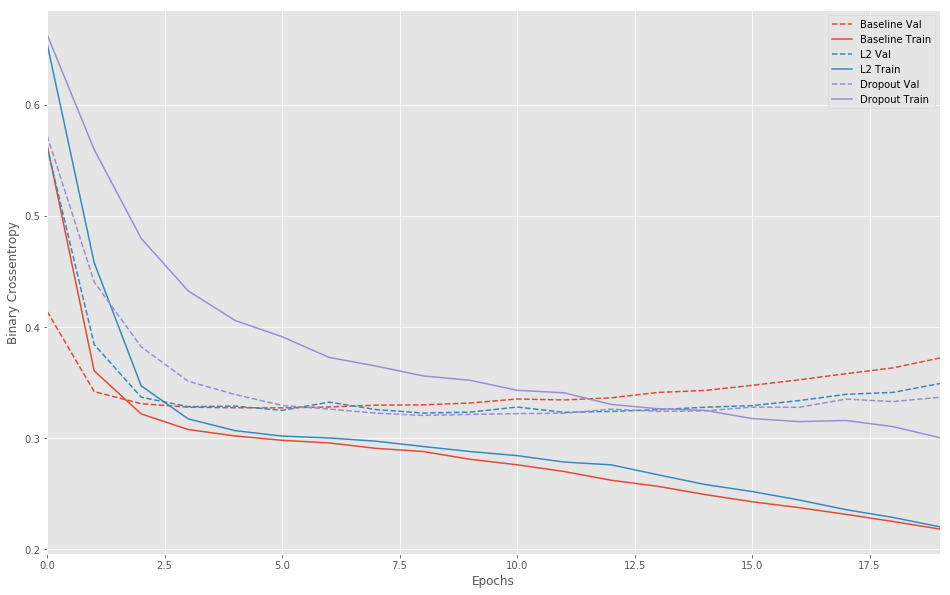

In [15]:
plot_history([('baseline', baseline_history), 
              ('l2', l2_model_history),
              ('dropout', dropout_model_history)])

    과적합이 앞선 두 방법보다 훨씬 늦게 발생함.

In [17]:
# L2 규제에 Dropout을 섞으면 어떻게 될까??
l2_dropout_model = keras.Sequential([
    keras.layers.Dense(16, kernel_regularizer=keras.regularizers.l2(0.001),
                       activation='relu', input_shape=(NUM_WORDS,)),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(16, kernel_regularizer=keras.regularizers.l2(0.001),
                       activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1, activation='sigmoid')
])

l2_dropout_model.compile(optimizer='adam',
                         loss='binary_crossentropy',
                         metrics=['accuracy', 'binary_crossentropy'])

with tf.device('/GPU:0'):
    l2_dropout_model_history = l2_dropout_model.fit(train_data, train_labels,
                                                    epochs=20, batch_size=512,
                                                    validation_data=(test_data, test_labels), verbose=2)

Epoch 1/20
49/49 - 0s - loss: 0.7207 - accuracy: 0.5637 - binary_crossentropy: 0.6751 - val_loss: 0.6337 - val_accuracy: 0.7591 - val_binary_crossentropy: 0.5914
Epoch 2/20
49/49 - 0s - loss: 0.6125 - accuracy: 0.6978 - binary_crossentropy: 0.5724 - val_loss: 0.4978 - val_accuracy: 0.8260 - val_binary_crossentropy: 0.4595
Epoch 3/20
49/49 - 0s - loss: 0.5270 - accuracy: 0.7702 - binary_crossentropy: 0.4899 - val_loss: 0.4267 - val_accuracy: 0.8442 - val_binary_crossentropy: 0.3906
Epoch 4/20
49/49 - 0s - loss: 0.4694 - accuracy: 0.8134 - binary_crossentropy: 0.4339 - val_loss: 0.3817 - val_accuracy: 0.8560 - val_binary_crossentropy: 0.3467
Epoch 5/20
49/49 - 0s - loss: 0.4380 - accuracy: 0.8339 - binary_crossentropy: 0.4033 - val_loss: 0.3763 - val_accuracy: 0.8555 - val_binary_crossentropy: 0.3418
Epoch 6/20
49/49 - 0s - loss: 0.4134 - accuracy: 0.8498 - binary_crossentropy: 0.3790 - val_loss: 0.3624 - val_accuracy: 0.8592 - val_binary_crossentropy: 0.3280
Epoch 7/20
49/49 - 0s - loss

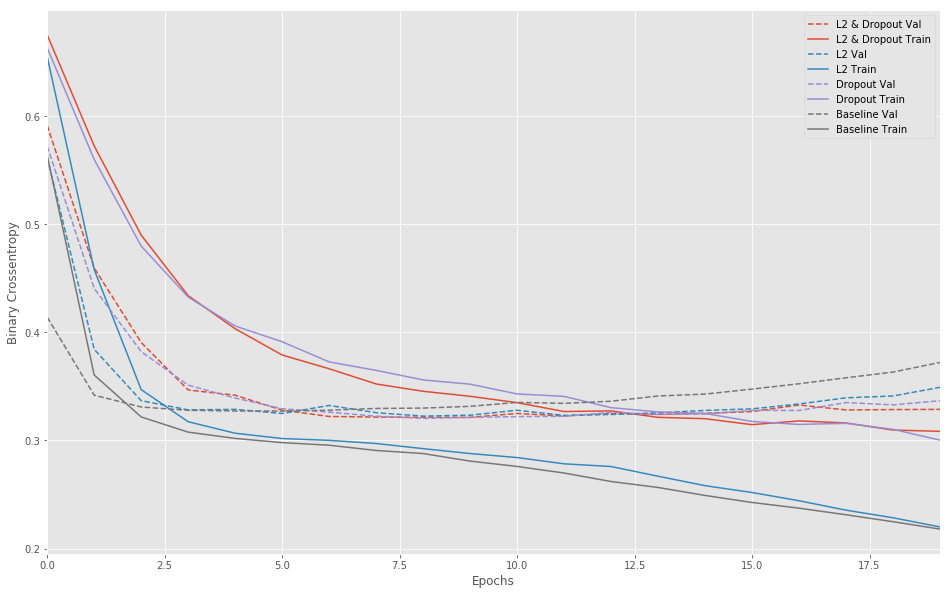

In [18]:
plot_history([('l2 & dropout', l2_dropout_model_history), 
              ('l2', l2_model_history),
              ('dropout', dropout_model_history),
              ('baseline', baseline_history)])

    드롭아웃 + L2 규제 하니 다른것보다 과적합이 많이 방지되는 것 같긴 하다.
    baseline보다 훨씬 더...

## 마치며

<br>

- 과적합 방지를 위해 가장 널리 사용하는 방법은 크게 4가지.
    - 더 많은 데이터 모으기
    - 네트워크 용량 줄이기
    - 가중치 규제 추가
    - 드롭아웃 추가
- 여기선 다루진 않았지만, **데이터 증식(data augmentation)**과 **배치 정규화(batch normalization)**도 있음.
    - 문서엔 나와있진 않은데 찾아서 돌려보라.